# Projet 7 : Implémentez un modèle de scoring

L'objectif est de développer un modèle de scoring de la probabilité de défaut de paiement d'un client pour étayer la décision d'accorder ou non un prêt à un client potentiel

Les données sont plusieurs fichiers '.csv' qui renseignent des informations concernant les clients d'une banque. 

Le fichier 'application_train' donne de multiples informations sur des clients qui ont effectué un emprunt ainsi que la mention remboursé ou défaut de payement sur cet emprunt. 

Le fichier application_test renseigne exactement les mêmes informations que le fichier 'application_train', mais il s'agit de déterminer la probabilité de défaut de paiement pour ces nouveaux emprunts.

Quant aux autres fichiers il s'agit d'informations relatives à des emprunts antérieurs qui ont été accordés soit par d'autres institutions soit par la même banque.

L'organigramme ci-dessous présente l'ensemble des fichiers à notre disposition, leur contenu ansi que les liens qui les relient.

<img src="home_credit.png">

Les données sont disponibles à l'adresse suivante : https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip

Cette partie est décomposé en 3 sous parties.

La première partie est une brève description des données 'application_train/test'.

    - Pour chaque variable numérique des jeux de données, il y a des informations concernant le pourcentage de données manquantes, la moyenne, la médianne, l'écart-type etc...
    - Pour chaque variable catégorielle, il y a des informations concernant  les données manquantes et pour chaque valeur prise par la variable il y a le nombre d'occurences
    
La deuxième partie s'intéresse au nettoyage des données.
    
    - Les individus dont les valeurs des variables catégorielles  sont non communes aux jeux test et d'entrainement sont supprimés ainsi que les individus dont les valeurs trop peu fréquentes
    - Les valeurs abérrantes de certaines variables numériques sont remplacés par 'NaN' pour une imputation ultérieure

## Table des matières

* [1. Description des données](#partie1)
* [2. Nettoyage des données](#partie2)
    * [2.1 Variables catégorielles](#Section_2_1)
    * [2.2 Variables numériques](#Section_2_2)
    * [2.3 Feature engineering](#Section_2_3)
        * [2.3.1 Feature Engineering automatisé](#sSection_2_3_1)
        * [2.3.2 Feature Engineering manuel](#sSection_2_3_2)
    * [2.4 Données manquantes](#Section_2_4)   
* [3. Encondage des variables catégorielles](#partie3)
    * [3.1 Encodage des 'variables temporelles'](#Section_3_1)
    * [3.2 Encodage des autres variables catégorielles](#Section_3_2)

#### Chargement des librairies

In [1]:
# Load packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Transformations de variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Feature engineering
import featuretools as ft
from featuretools import selection

# Data Augmentation
from imblearn.over_sampling import SMOTE

# Metrics de ML
from sklearn.metrics import auc, roc_curve, roc_auc_score, make_scorer
from sklearn.metrics import precision_recall_curve

# Packages de cross_validation
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

# Packages hyperopt pour la séléction d'hyperparamètres
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

# Modèles de ML
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import ElasticNet
from xgboost import plot_importance

# Librairies graphiques
import plotly.offline as py
import plotly.graph_objs as go
import plotly.offline as offline
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()

Using TensorFlow backend.


## 1. Description des données <a class="anchor" id="partie1"></a>

#### Lecture des données

In [2]:
# Lecture des données
train_set = pd.read_csv('application_train.csv').sort_values("SK_ID_CURR")
test_set = pd.read_csv('application_test.csv').sort_values("SK_ID_CURR")
bureau = pd.read_csv("bureau.csv").sort_values(['SK_ID_CURR', 'SK_ID_BUREAU'])
bureau_balance = pd.read_csv("bureau_balance.csv").sort_values("SK_ID_BUREAU")
cash_balance = pd.read_csv("POS_CASH_balance.csv").sort_values([
    'SK_ID_CURR', 'SK_ID_PREV'])
card_balance = pd.read_csv('credit_card_balance.csv').sort_values([
    'SK_ID_CURR', 'SK_ID_PREV'])
prev_app = pd.read_csv('previous_application.csv').sort_values(
    ['SK_ID_CURR', 'SK_ID_PREV'])
payments = pd.read_csv('installments_payments.csv').sort_values(
    ['SK_ID_CURR', 'SK_ID_PREV'])

#### Apperçu des données

In [3]:
# Affiche les 5 premières lignes des données d'entrainement
train_set.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


#### Structure des données

In [4]:
def describe_columns_df(df):
    """
    Affiche la description détaillée du contenu de chaque colonne de df
    df(pd.Dataframe): jeu de données
    """
    for col in df:
        print(col)
        null = df[col].isnull().sum()
        # affiche le nombre de valeurs manquantes
        print('Number of empty : ', null)
        # affiche le pourcentage de valeurs manquantes
        print('Percent of empty : ', 100*null/df.shape[0])
        print(df[col].describe())
        if df[col].dtype == object:
            print('Categories and Count:')
            print(df[col].value_counts().to_string(header=None))
        print('\n')

In [5]:
# Affiche la description détaillée du contenu
# de chaque colonne du jeu d'entrainement
describe_columns_df(train_set)

SK_ID_CURR
Number of empty :  0
Percent of empty :  0.0
count    307511.000000
mean     278180.518577
std      102790.175348
min      100002.000000
25%      189145.500000
50%      278202.000000
75%      367142.500000
max      456255.000000
Name: SK_ID_CURR, dtype: float64


TARGET
Number of empty :  0
Percent of empty :  0.0
count    307511.000000
mean          0.080729
std           0.272419
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: TARGET, dtype: float64


NAME_CONTRACT_TYPE
Number of empty :  0
Percent of empty :  0.0
count         307511
unique             2
top       Cash loans
freq          278232
Name: NAME_CONTRACT_TYPE, dtype: object
Categories and Count:
Cash loans         278232
Revolving loans     29279


CODE_GENDER
Number of empty :  0
Percent of empty :  0.0
count     307511
unique         3
top            F
freq      202448
Name: CODE_GENDER, dtype: object
Categories and Count:
F      202448


Name: YEARS_BEGINEXPLUATATION_AVG, dtype: float64


YEARS_BUILD_AVG
Number of empty :  204488
Percent of empty :  66.49778381911541
count    103023.000000
mean          0.752471
std           0.113280
min           0.000000
25%           0.687200
50%           0.755200
75%           0.823200
max           1.000000
Name: YEARS_BUILD_AVG, dtype: float64


COMMONAREA_AVG
Number of empty :  214865
Percent of empty :  69.87229725115525
count    92646.000000
mean         0.044621
std          0.076036
min          0.000000
25%          0.007800
50%          0.021100
75%          0.051500
max          1.000000
Name: COMMONAREA_AVG, dtype: float64


ELEVATORS_AVG
Number of empty :  163891
Percent of empty :  53.29597965601231
count    143620.000000
mean          0.078942
std           0.134576
min           0.000000
25%           0.000000
50%           0.000000
75%           0.120000
max           1.000000
Name: ELEVATORS_AVG, dtype: float64


ENTRANCES_AVG
Number of empty :  154828
Percent of

Name: BASEMENTAREA_MEDI, dtype: float64


YEARS_BEGINEXPLUATATION_MEDI
Number of empty :  150007
Percent of empty :  48.781019215572776
count    157504.000000
mean          0.977752
std           0.059897
min           0.000000
25%           0.976700
50%           0.981600
75%           0.986600
max           1.000000
Name: YEARS_BEGINEXPLUATATION_MEDI, dtype: float64


YEARS_BUILD_MEDI
Number of empty :  204488
Percent of empty :  66.49778381911541
count    103023.000000
mean          0.755746
std           0.112066
min           0.000000
25%           0.691400
50%           0.758500
75%           0.825600
max           1.000000
Name: YEARS_BUILD_MEDI, dtype: float64


COMMONAREA_MEDI
Number of empty :  214865
Percent of empty :  69.87229725115525
count    92646.000000
mean         0.044595
std          0.076144
min          0.000000
25%          0.007900
50%          0.020800
75%          0.051300
max          1.000000
Name: COMMONAREA_MEDI, dtype: float64


ELEVATORS_MEDI
Number of 

Name: FLAG_DOCUMENT_6, dtype: float64


FLAG_DOCUMENT_7
Number of empty :  0
Percent of empty :  0.0
count    307511.000000
mean          0.000192
std           0.013850
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: FLAG_DOCUMENT_7, dtype: float64


FLAG_DOCUMENT_8
Number of empty :  0
Percent of empty :  0.0
count    307511.000000
mean          0.081376
std           0.273412
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: FLAG_DOCUMENT_8, dtype: float64


FLAG_DOCUMENT_9
Number of empty :  0
Percent of empty :  0.0
count    307511.000000
mean          0.003896
std           0.062295
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: FLAG_DOCUMENT_9, dtype: float64


FLAG_DOCUMENT_10
Number of empty :  0
Percent of empty :  0.0
count    307511.000000
mean          0.0000

In [6]:
# Affiche la description détaillée du contenu de chaque colonne du jeu test
describe_columns_df(test_set)

SK_ID_CURR
Number of empty :  0
Percent of empty :  0.0
count     48744.000000
mean     277796.676350
std      103169.547296
min      100001.000000
25%      188557.750000
50%      277549.000000
75%      367555.500000
max      456250.000000
Name: SK_ID_CURR, dtype: float64


NAME_CONTRACT_TYPE
Number of empty :  0
Percent of empty :  0.0
count          48744
unique             2
top       Cash loans
freq           48305
Name: NAME_CONTRACT_TYPE, dtype: object
Categories and Count:
Cash loans         48305
Revolving loans      439


CODE_GENDER
Number of empty :  0
Percent of empty :  0.0
count     48744
unique        2
top           F
freq      32678
Name: CODE_GENDER, dtype: object
Categories and Count:
F    32678
M    16066


FLAG_OWN_CAR
Number of empty :  0
Percent of empty :  0.0
count     48744
unique        2
top           N
freq      32311
Name: FLAG_OWN_CAR, dtype: object
Categories and Count:
N    32311
Y    16433


FLAG_OWN_REALTY
Number of empty :  0
Percent of empty :  0.0


IT staff                   81


CNT_FAM_MEMBERS
Number of empty :  0
Percent of empty :  0.0
count    48744.000000
mean         2.146767
std          0.890423
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         21.000000
Name: CNT_FAM_MEMBERS, dtype: float64


REGION_RATING_CLIENT
Number of empty :  0
Percent of empty :  0.0
count    48744.000000
mean         2.038159
std          0.522694
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: REGION_RATING_CLIENT, dtype: float64


REGION_RATING_CLIENT_W_CITY
Number of empty :  0
Percent of empty :  0.0
count    48744.000000
mean         2.012596
std          0.515804
min         -1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: REGION_RATING_CLIENT_W_CITY, dtype: float64


WEEKDAY_APPR_PROCESS_START
Number of empty :  0
Percent of empty :  0.0
count       48744
unique       

Name: ENTRANCES_AVG, dtype: float64


FLOORSMAX_AVG
Number of empty :  23321
Percent of empty :  47.84383719021828
count    25423.000000
mean         0.233706
std          0.147361
min          0.000000
25%          0.166700
50%          0.166700
75%          0.333300
max          1.000000
Name: FLOORSMAX_AVG, dtype: float64


FLOORSMIN_AVG
Number of empty :  32466
Percent of empty :  66.60512063023141
count    16278.000000
mean         0.238423
std          0.164976
min          0.000000
25%          0.104200
50%          0.208300
75%          0.375000
max          1.000000
Name: FLOORSMIN_AVG, dtype: float64


LANDAREA_AVG
Number of empty :  28254
Percent of empty :  57.96405711472181
count    20490.000000
mean         0.067192
std          0.081909
min          0.000000
25%          0.019000
50%          0.048300
75%          0.086800
max          1.000000
Name: LANDAREA_AVG, dtype: float64


LIVINGAPARTMENTS_AVG
Number of empty :  32780
Percent of empty :  67.24930247825374
count  

Name: ENTRANCES_MEDI, dtype: float64


FLOORSMAX_MEDI
Number of empty :  23321
Percent of empty :  47.84383719021828
count    25423.000000
mean         0.233154
std          0.147629
min          0.000000
25%          0.166700
50%          0.166700
75%          0.333300
max          1.000000
Name: FLOORSMAX_MEDI, dtype: float64


FLOORSMIN_MEDI
Number of empty :  32466
Percent of empty :  66.60512063023141
count    16278.000000
mean         0.237846
std          0.165241
min          0.000000
25%          0.083300
50%          0.208300
75%          0.375000
max          1.000000
Name: FLOORSMIN_MEDI, dtype: float64


LANDAREA_MEDI
Number of empty :  28254
Percent of empty :  57.96405711472181
count    20490.000000
mean         0.068069
std          0.082869
min          0.000000
25%          0.019000
50%          0.048800
75%          0.088000
max          1.000000
Name: LANDAREA_MEDI, dtype: float64


LIVINGAPARTMENTS_MEDI
Number of empty :  32780
Percent of empty :  67.24930247825374

#### Variable 'TARGET'

La nom de la colonne dont on cherche à prédire la valeur est "TARGET".

La variable prend soit la valeur 0 quand le prêt a été remboursé sans soucis, soit la valeur 1 quand il y a eu un défaut de payement.

In [7]:
def solvability_clients(df):
    """
    Pieplot de la solvabilité clients
    df(pd.DataFrame): jeu de données
    """
    # % de valeurs 'TARGET' différentes
    target_values = df['TARGET'].value_counts()/len(df)*100
    # Pieplot du % de chaque valeurs différentes de 'TARGET'
    plt.pie(target_values,
            colors=['#2ecc71', '#e74c3c'],
            autopct='%1.1f%%',
            labels=["Solvable", "Non Solvable"],
            startangle=90)
    plt.show()

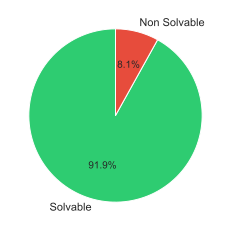

In [8]:
# Pieplot solvabilité clients du jeu d'entrainement
solvability_clients(train_set)

92 % des prêts ont été remboursés et donc 8 % des individus ont été non solvables.

## 2. Nettoyage des données <a class="anchor" id="partie2"></a>

Dans cette partie, les jeu de données d'entrainement et de test sont concaténés pour traiter les features de manière conjointe

In [9]:
def merge_train_test(df_train, df_test):
    """
    Merge les jeu d'entrainement et de test en rajoutant
    une colonne 'Test' qui prend les valeurs True ou False
    df_train(pd.DataFrame): jeu d'entrainement
    df_test(pd.DataFrame): jeu test
    """

    df_train['Test'] = False
    df_test['Test'] = True
    df_test['TARGET'] = np.nan
    app = train_set.append(test_set,
                           ignore_index=True,
                           sort=False)
    return app

In [10]:
# Merge jeu d'entrainement et jeu de test
app = merge_train_test(train_set, test_set)

### 2.1 Variables catégorielles <a class="anchor" id="Section_2_1"></a>

#### Liste des variables catégorielles et valeurs prises

In [11]:
def display_cat_columns(app):
    """
    Pour chaque colonne catégorielle, indique le nombre et le nom
    des différentes valeurs prises
    """

    for col in app:
        if app[col].dtype == object:
            print(col)
            print('Number Unique in Train:', app[~app['Test']][col].nunique())
            print('Number Unique in Test: ', app[app['Test']][col].nunique())
            print('Unique in Train: ',
                  sorted([str(e) for e in
                          app[~app['Test']][col].unique().tolist()]))
            print('Unique in Test: ',
                  sorted([str(e) for e in
                          app[app['Test']][col].unique().tolist()]))
            print('\n')

In [12]:
# Descriptif des variables catégorielles
display_cat_columns(app)

NAME_CONTRACT_TYPE
Number Unique in Train: 2
Number Unique in Test:  2
Unique in Train:  ['Cash loans', 'Revolving loans']
Unique in Test:  ['Cash loans', 'Revolving loans']


CODE_GENDER
Number Unique in Train: 3
Number Unique in Test:  2
Unique in Train:  ['F', 'M', 'XNA']
Unique in Test:  ['F', 'M']


FLAG_OWN_CAR
Number Unique in Train: 2
Number Unique in Test:  2
Unique in Train:  ['N', 'Y']
Unique in Test:  ['N', 'Y']


FLAG_OWN_REALTY
Number Unique in Train: 2
Number Unique in Test:  2
Unique in Train:  ['N', 'Y']
Unique in Test:  ['N', 'Y']


NAME_TYPE_SUITE
Number Unique in Train: 7
Number Unique in Test:  7
Unique in Train:  ['Children', 'Family', 'Group of people', 'Other_A', 'Other_B', 'Spouse, partner', 'Unaccompanied', 'nan']
Unique in Test:  ['Children', 'Family', 'Group of people', 'Other_A', 'Other_B', 'Spouse, partner', 'Unaccompanied', 'nan']


NAME_INCOME_TYPE
Number Unique in Train: 8
Number Unique in Test:  7
Unique in Train:  ['Businessman', 'Commercial associate

##### Variable 'CODE_GENDER'

Le jeu d'entrainement contient seulement 4 valeurs nommés 'XNA' pour la colonne renseignant le genre. Ces emprunts sont supprimés

In [13]:
# Supprime les individus dont le genre est 'XNA'
app = app[app['CODE_GENDER'] != 'XNA']

##### Variable 'NAME_INCOME_TYPE' 

La colonne 'NAME_INCOME_TYPE' prend la valeur 'Maternity leave' uniquement pour le jeu d'entrainement , et pour seulement 5 emprunteurs. Les lignes renseignant ces emprunts sont supprimés 

In [14]:
# Supprime les individus dont 'NAME_INCOME_TYPE' vient d'un congé maternité
app = app[app['NAME_INCOME_TYPE'] != 'Maternity leave']

##### Variable 'NAME_FAMILY_STATUS' 

De la même manière, pour la colonne NAME_FAMILY_STATUS, il y a seulement deux fois la valeur Unknown  et uniquement pour le jeu d'entrainement. Les lignes correspondantes sont supprimés

In [15]:
# Supprime les individus dont la statut familial est inconnu
app = app[app['NAME_FAMILY_STATUS'] != 'Unknown']

### 2.2 Variables numériques<a class="anchor" id="Section_2_2"></a>

##### Variable 'DAYS_EMPLOYED'

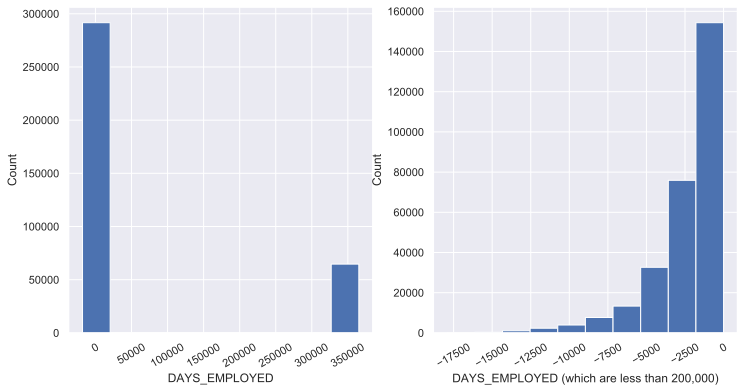

In [16]:
# Affiche l'histogramme du nombre de jours employés
fig = plt.figure(1, figsize=(12, 6))
plt.subplot(1, 2, 1)
app['DAYS_EMPLOYED'].hist()
plt.xlabel('DAYS_EMPLOYED')
plt.ylabel('Count')
plt.xticks(rotation=30)

# Affiche l'histogramme pour les valeurs normales
plt.subplot(1, 2, 2)
app.loc[app['DAYS_EMPLOYED'] < 200000, 'DAYS_EMPLOYED'].hist()
plt.xlabel('DAYS_EMPLOYED (which are less than 200,000)')
plt.ylabel('Count')
plt.xticks(rotation=30)
plt.show()

In [17]:
# Affiche les valeurs abérrantes
values_to_nan = app.loc[app['DAYS_EMPLOYED'] > 366, 'DAYS_EMPLOYED'].unique()
print(values_to_nan)

[365243]


In [18]:
# Remplace la valeur abérrante par NaN
app['DAYS_EMPLOYED'].replace(values_to_nan, np.nan, inplace=True)

In [19]:
# Sauvegarde des résultats
app.to_csv("app_no_encoded_no_featureengineering.csv")